### 2. Aplicación: Prediciendo las acciones de Netflix
***

#### Cargamos librerias básicas para el manejo de datos, gráficas y cálculos en python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Ubicamos en nuestro espacio de trabajo las bases de datos que usaremos

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving NFLX1.csv to NFLX1 (1).csv


Importamos el  Dataset de entrenamiento el cual consta de 1677 datos con información diaria de las acciones de Netflix desde el 2 de enero del 2014 hasta el 31 de agosto del 2020

In [ ]:
nt_completa= pd.read_csv(r'NFLX1.csv')

Un vistazo de la estructura de la base de datos nos muestra lo siguiente

In [ ]:
nt_completa.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-01-02,52.401428,52.511429,51.542858,51.831429,51.831429,12325600
1,2014-01-03,52.000000,52.495716,51.842857,51.871429,51.871429,10817100
2,2014-01-06,51.889999,52.044285,50.475716,51.367142,51.367142,15501500
3,2014-01-07,49.684284,49.698570,48.152859,48.500000,48.500000,36167600
4,2014-01-08,48.104286,49.425713,48.074287,48.712856,48.712856,20001100


In [ ]:
len(nt_completa)

1677

In [ ]:
print(nt_completa.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [ ]:
nt_completa.sort_values('Date', ascending=True, inplace=True)

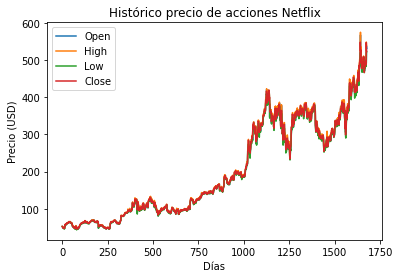

In [ ]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(nt_completa["Open"])
plt.plot(nt_completa["High"])
plt.plot(nt_completa["Low"])
plt.plot(nt_completa["Close"])
plt.title('Histórico precio de acciones Netflix')
plt.ylabel('Precio (USD)')
plt.xlabel('Días')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

In [ ]:
print("Verificación de que no existan NAs en la base\n", nt_completa.isna().sum())

Verificación de que no existan NAs en la base
 Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


#### Elegimos la columna de interés: **Open**

In [ ]:
nt_processed = nt_completa.iloc[:,1:2].values

Para la decisión del número de covariables se dará un primer vistazo al gráfico de la función de autocovarianza para 300 rezagos 

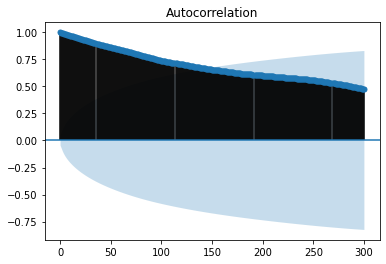

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import pyplot
plot_acf(nt_processed,lags=300)
pyplot.show()

Se puede ver en la grafica de autocorrelación que existe una alta correlación en los primeros 300 rezagos, aún así, parecen se los primeros 60 rezagos los más correlacionados por lo que se decide tomar estos como autocovariables.

#### Escalamiento de los datos

Por regla general al trabajar con redes neuronales se deben normalizar o escalar los datos, en este caso utilizaremos el comando MinMaxScaler del paquete sklearn para escalar los datos entre 0 y 1

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1))

nt_training_scaled = scaler.fit_transform(nt_processed)

#### Creación de variables rezagadas

El objetivo de nuestro proyecto es poder predecir el valor de la acción de apertura de Netflix en el tiempo T basandonos en los datos de los días T-N para cualquier número de pasos N. Para nuestro caso se ha decidido utilizar N=60.

In [ ]:
features_set = []
labels = []
for i in range(60, 1677):
    features_set.append(nt_training_scaled[i-60:i, 0])
    labels.append(nt_training_scaled[i, 0])

Lo que hicimos previamente fue crear dos listas(features_set y labels). Para ello creamos un ciclo que comienza desde el registro 61 y almacena los 60 registros previos en features_set y el registro 61 en la lista "labels".

Esto se puede obsevar más claramente con el siguiente conjunto de datos

In [ ]:
features_set[0:2]

[array([0.01489511, 0.01412811, 0.01391793, 0.00970352, 0.00668465,
        0.00806034, 0.00705041, 0.00515611, 0.00797026, 0.00621244,
        0.00441367, 0.00541268, 0.00545636, 0.00471119, 0.02051523,
        0.01949984, 0.0205125 , 0.01885567, 0.02480607, 0.02589243,
        0.02458498, 0.02720261, 0.02544205, 0.02481426, 0.02570682,
        0.02762296, 0.03198749, 0.03213215, 0.03344779, 0.03096665,
        0.03407013, 0.03404283, 0.0325989 , 0.03223861, 0.03451778,
        0.03363613, 0.03760215, 0.03921259, 0.03701257, 0.0384565 ,
        0.03519743, 0.03785328, 0.03869124, 0.03895056, 0.03871308,
        0.03718454, 0.03559322, 0.03314754, 0.03479346, 0.03152347,
        0.03164902, 0.03006043, 0.02937805, 0.02932346, 0.03107856,
        0.02545297, 0.01822242, 0.01658742, 0.01604151, 0.01309634]),
 array([0.01412811, 0.01391793, 0.00970352, 0.00668465, 0.00806034,
        0.00705041, 0.00515611, 0.00797026, 0.00621244, 0.00441367,
        0.00541268, 0.00545636, 0.00471119, 0.

In [ ]:
labels[0:2]

[0.013448452558329535, 0.01078441825646731]

Para poder usar dichos datos para nuestro entrenamientro es necesario convertir nuestra lista como una matriz numpy con el siguiente código

In [ ]:
features_set, labels = np.array(features_set), np.array(labels)

#### División de la variable entre entrenamiento y prueba

Para nuestro caso hemos decidido utilizar el 90% de los datos como entrenamiento y el 10/ como validación

In [ ]:
from sklearn.model_selection import train_test_split
features_train, features_test, labels_train, labels_test=train_test_split(features_set,labels,test_size=0.1, train_size=0.9)

Con lo que obtenemos que las siguientes dimensiones para el entrenamiento y prueba

In [ ]:
print(features_train.shape)
print(features_test.shape)

print(labels_train.shape)
print(labels_test.shape)

(1455, 60)
(162, 60)
(1455,)
(162,)


#### Cambio de forma de los datos como input de la red LSTM

Por último, para moder entrenar nuestros datos, será necesario expresar nuestra matriz en formato de tres dimensiones ya que este es el formato aceptado por las redes LSTM.
*   Primera dimensión: Número de filas o registros de nuestra base de entrenamiento (1455 en nuestro caso)
*   Segunda dimensión: Número de pasos de tiempo previos (60) 
*   Tercera dimensión: Número de features, como sólo estamos trabajando **Open** nuestro indicador es 1





In [ ]:
features_train = np.reshape(features_train, (features_train.shape[0], features_train.shape[1], 1))

In [ ]:
features_train

array([[[0.10049077],
        [0.10177094],
        [0.1011213 ],
        ...,
        [0.10773225],
        [0.10639478],
        [0.10813349]],

       [[0.57120555],
        [0.57395693],
        [0.5918791 ],
        ...,
        [0.48539697],
        [0.478423  ],
        [0.47888154]],

       [[0.03188923],
        [0.03023239],
        [0.03119593],
        ...,
        [0.04593271],
        [0.04554785],
        [0.04394288]],

       ...,

       [[0.59571959],
        [0.58586048],
        [0.58532549],
        ...,
        [0.50905118],
        [0.5142291 ],
        [0.49840868]],

       [[0.10110766],
        [0.10220766],
        [0.10826997],
        ...,
        [0.10566872],
        [0.11140076],
        [0.11159182]],

       [[0.01309634],
        [0.01344845],
        [0.01078442],
        ...,
        [0.03744657],
        [0.03520016],
        [0.03469792]]])

####Entrenando el LSTM

Una vez hemos adecuado nuestra base para el entrenamiento podemos proceder a la creación de nuestro modelo.
Nuestro LSTM será un modelo secuencial con cuatro capas seguido de una capa densa.

Así que empezamos importando las librerias para la construcción del modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

El primer paso será inicializar la clase secuencial al modelo y posteriormente añadirle las capas LSTM y la capa densa al modelo

In [ ]:
model = Sequential()



*   units="Número de neuronas que deseamos en la capa"
*   return_sequences="True" si se le añadiran más capas al modelo
*   input_shape[1,]=el primer parametro es el número de pasos de tiempo N
*   input_shape[,2]=el segundo parametro es el número de indicadores



In [ ]:
model.add(LSTM(units=50, return_sequences=True, input_shape=(features_train.shape[1], 1)))

Añadimos una capa "Dropout" la cual se utilizá para evitar el sobre ajuste de nuestro modelo

In [ ]:
model.add(Dropout(0.2))

Realizamos los mismos pasos para crear otras tres capas

In [ ]:
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

y finalmente añadimos una capa densa y como solo deseamos predecir un valor dados los 60 valores previos, el valor de units=1

In [ ]:
model.add(Dense(units = 1))

#### Compilación del modelo

El paso previo al entrenamiento es compilar el modelo

In [ ]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

En este caso usamos la funcion de perdida del cuadrado medio del error y el optimizador escogido para reducir dicha función de perdida es "adam"

#### Entrenamiento

Por último, para entrenar el modelo utilizamos la función "fit" con los siguientes parámetros

Este proceso puede tradar unos minutos dependiendo la maquina que lo ejecute

In [ ]:
history=model.fit(features_train, labels_train, epochs = 100, batch_size = 32,validation_split=0.1)

Epoch 1/100
41/41 [==============================] - 6s 143ms/step - loss: 0.0201 - val_loss: 0.0053
Epoch 2/100
41/41 [==============================] - 5s 113ms/step - loss: 0.0047 - val_loss: 0.0018
Epoch 3/100
41/41 [==============================] - 5s 113ms/step - loss: 0.0035 - val_loss: 0.0016
Epoch 4/100
41/41 [==============================] - 5s 111ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 5/100
41/41 [==============================] - 5s 112ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 6/100
41/41 [==============================] - 4s 109ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 7/100
41/41 [==============================] - 5s 111ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 8/100
41/41 [==============================] - 4s 108ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 9/100
41/41 [==============================] - 5s 110ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 10/100
41/41 [==============================] - 4s 108ms/step - loss: 0.0022 - val_lo

Para graficar la función de perdida ejecutamos el siguiente código

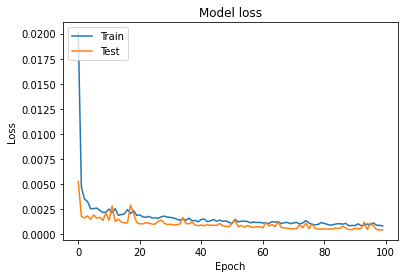

In [ ]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

En la grafica anterior se nota el rapido descenso de la función de perdida, lo que nos sugiere que el modelo se esta ajustando bien a los datos y por ende, el error cuadratico medio está disminuyendo

#### Testeo de nuestro modelo LSTM

Hemos entrenado exitosamente nuestro modelo, nuestro siguiente paso será observar que tan bien se ajusta a datos que no estuvieron presentes  en el entrenamiento. En nuestro caso nuestros datos de testeo serán el valor de la apertura de las acciones de Netflix los 162 días posteriores a los datos de entrenamiento.


Como requerimos de los 60 registros previos para poder predecir en nuestro modelo, el siguiente paso es añadir nuestros 60 datos previos al primer valor de testeo

In [ ]:
test_inputs =nt_training_scaled[len(nt_training_scaled) - len(features_test) - 60:]

In [ ]:
len(test_inputs)

222

Creamos nuestro conjunto de 60 datos para los test_feature, los convertimos en matrices y los escribimos en su formato de tercera dimensión

In [ ]:
test_features = []
for i in range(60,222):
    test_features.append(test_inputs[i-60:i, 0])

In [ ]:
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))

#### Predicciones

Ya que hemos preprocesado nuestros datos de testeo los podemos usar para realizar predicciones, basta con hacer uso de la función predict en el modelo que creamos.

In [ ]:
predictions = model.predict(test_features)

Como los datos estuvieron escalados al entrar al modelo, su predicción también estará escalada por lo que ejecutamos la función inverse_transform como sigue

In [ ]:
predictions = scaler.inverse_transform(predictions)

In [ ]:
label_test1=nt_processed[1515:1677]

Finalmente miremos qué tan bien está prediciendo nuestro modelo

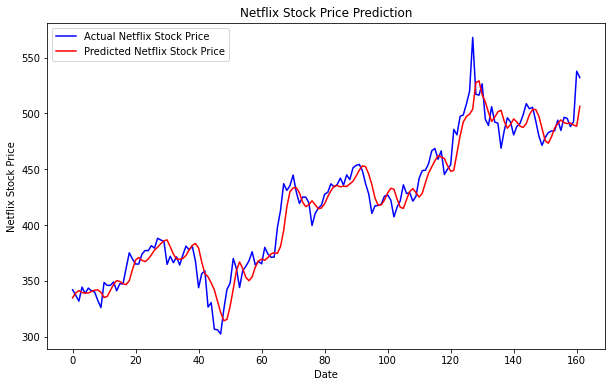

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(label_test1, color='blue', label='Actual Netflix Stock Price')
plt.plot(predictions , color='red', label='Predicted Netflix Stock Price')
plt.title('Netflix Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Netflix Stock Price')
plt.legend()
plt.show()

In [ ]:
error=mean_squared_error(label_test1,predictions)
print("El error es", error, predictions.shape, label_test1.shape)

El error es 212.66488348209447 (162, 1) (162, 1)


Podemos apreciar que el modelo logra capturar gran parte del comportamiento del modelo 